In [1]:
import numpy as np
import scipy as sci
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from nilearn import plotting as ni_plt

import json, pickle
from tqdm import tqdm
import sys, os, pdb
import pandas as pd
import xarray as xr

from src.data_utils import ECoG_Data
import src.manifold_u as mu
import fig_utils as figu

import importlib
importlib.reload(mu)
importlib.reload(figu)

from scipy.io import loadmat

In [2]:
filepath = '/home/zsteineh/research_projects/NaturalisticNeuralManifolds/experiment_params/'
file_name = 'exp_params_nat_pca.json'
try:
    json_filename = filepath + file_name
except IndexError:
    raise SystemExit(f"Usage: {sys.argv[0]} <json file of experiment parameters>")
with open(json_filename) as f:
    exp_params = json.load(f)
print(exp_params['comment'])

Param file for running PCA pipeline on naturalistic data


In [3]:
freq_bands = exp_params["freq_bands"]
class_dict = exp_params["class_dict"]
class_dict = {int(cur_key): val for cur_key, val in class_dict.items()}
class_color = exp_params["class_color"]
class_color = {int(cur_key): val for cur_key, val in class_color.items()}

proj_mat_sp = exp_params["sp"] + exp_params["dataset"] + exp_params["experiment_folder"]

percent_threshold = 0.8
pats_ids_in = exp_params["pats_ids_in"]
freq_red_dim = {"LFO": 8,
                "Alpha": 9,
                "Beta": 10,
                "Low Gamma": 11,
                "Gamma": 10,
                "High Gamma": 9}

In [4]:
# color dicts for all slices of data
movement_colors, day_colors, participant_colors, exp_class_colors, exp_participant_colors, freq_colors = mu.get_all_colors()

In [5]:
def load_elec_pos_nat(sbj_num):
    mni_elec_lp = '/data1/ecog_project/derived/processed_ecog/'
    # need a dict here to modify and pull in the correct electrode info
    elec_sbj_name_dict = {
        1: "a0f66459",
        2: "c95c1e82",
        3: "cb46fd46",
        4: "fcb01f7a",
        5: "ffb52f92",
        6: "b4ac1726",
        7: "f3b79359",
        8: "ec761078",
        9: "f0bbc9a9",
        10: "abdb496b",
        11: "ec168864",
        12: "b45e3f7b",
    }
    sbj_name = elec_sbj_name_dict[sbj_num + 1]
    lp = mni_elec_lp+sbj_name+'/elec_locs/'
    
    #Load electrode MNI locations into dataframe
    fin = loadmat(lp+sbj_name+'_elec_mni_frv.mat')
    chanpos = fin['elec_mni_frv']['chanpos'][0][0]
    label = fin['elec_mni_frv']['label'][0][0]
    df_elec_pos = pd.DataFrame(chanpos,columns=['X coor','Y coor','Z coor'],index=label)

    return df_elec_pos

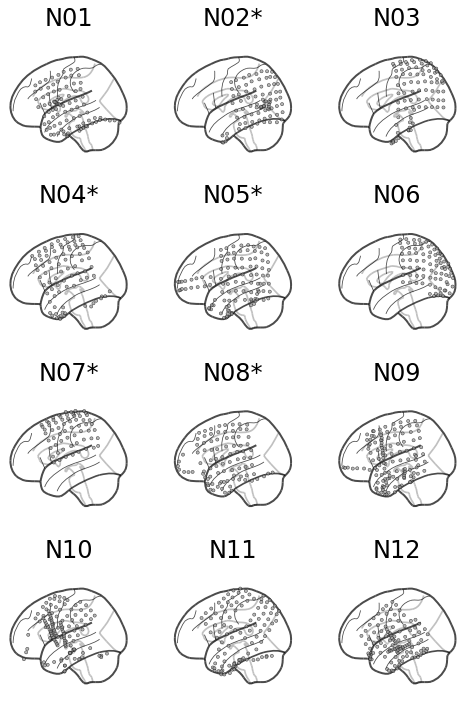

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(7, 10))
plt.tight_layout()

# plot the electrodes
for i in range(12):
    elec_pos_df = load_elec_pos_nat(i)
    figu.plot_electrodes(axes[i//3, i%3], 
                    elec_pos_df,
                    i, 
                    electrode_color=[2 for i in range(len(elec_pos_df))],
                    side_2_display="l", 
                    colorbar=False, 
                    alpha=1.0, 
                    node_size=10, 
                    edgecolors='black')
    

plt.savefig('/home/zsteineh/research_projects/NaturalisticNeuralManifolds/figures/saved_figures/methods_nat_elecs.svg', bbox_inches='tight') 
plt.show()

In [7]:
cross_move_pas = pickle.load(open(proj_mat_sp + 'freq_cross_move_pas.pkl', 'rb'))
print(cross_move_pas.keys())

dict_keys(['LFO', 'Alpha', 'Beta', 'Low Gamma', 'Gamma', 'High Gamma'])


In [8]:
null_data_pa = np.load(exp_params['null_data_lp'] + 'TME_null_pas.npy')
print(null_data_pa.shape)

(6, 12, 1000, 1, 1, 10, 15)


In [9]:
cross_move_nd_df = pd.read_csv(proj_mat_sp + 'freq_cross_move_nd_df.csv')
cross_move_nd_df

,Unnamed: 0,Frequency,Participant,Day,Movement Comparison,Neural Dissimilarity
0,0,LFO,P01,3,left vs down,0.108478
1,1,LFO,P01,3,left vs right,NaN
2,2,LFO,P01,3,left vs up,NaN
3,3,LFO,P01,3,down vs right,NaN
4,4,LFO,P01,3,down vs up,NaN
...,...,...,...,...,...,...
434155,72355,High Gamma,Null,Null,left vs right,0.799577
434156,72356,High Gamma,Null,Null,left vs up,0.788575
434157,72357,High Gamma,Null,Null,down vs right,0.799842
434158,72358,High Gamma,Null,Null,down vs up,0.787117


/home/zsteineh/research_projects/NaturalisticNeuralManifolds/figures/fig_utils.py:117: RuntimeWarning: Mean of empty slice
  theta_vals = np.nanmean(all_day_pas, axis=0)[
/home/zsteineh/anaconda3/envs/ECoGDL_venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


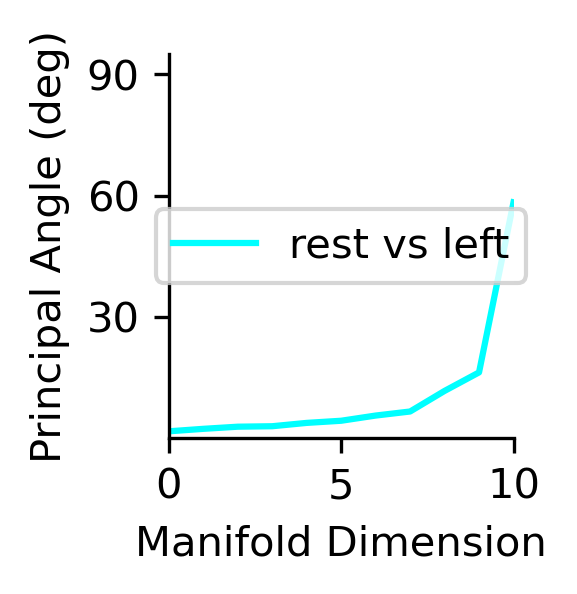

In [10]:
# PA figure
fig, ax0 = plt.subplots(1, 1, figsize=(2, 2), dpi=300)
import matplotlib
matplotlib.rcParams.update({'font.size': 10})
comps_to_plot = [0]
figu.plot_PAs(ax0, 
    class_dict, 
    comps_to_plot, 
    np.expand_dims(cross_move_pas['Beta'], axis = 0),
    red_dim = freq_red_dim['Beta'], 
    null_data_pa = null_data_pa,)

plt.tight_layout()
plt.show()

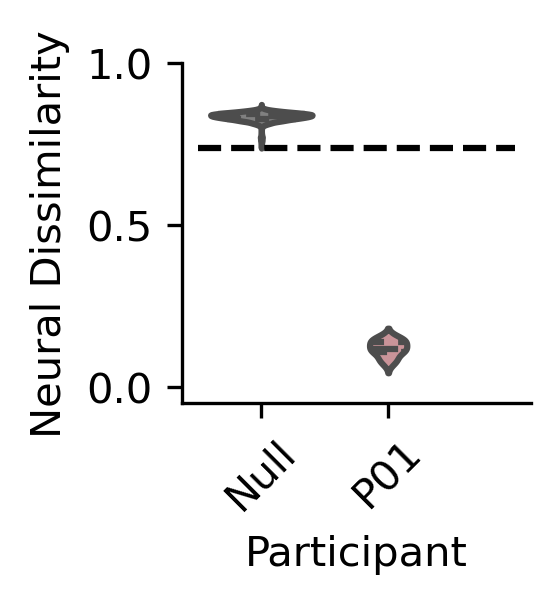

In [11]:
fig, ax0 = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=300)
# pull the current freq data out
q1_sigf_val = mu.calc_sumed_significance(cross_move_nd_df)
cur_freq_only = cross_move_nd_df.loc[
    (cross_move_nd_df["Frequency"] == 'Beta')
    | (cross_move_nd_df["Frequency"] == "Null")
]
order = ['Null', 'P01']
participant_colors['P01'] = '#d38b91'
figu.plot_neural_dissimilarity(ax0, cur_freq_only, q1_sigf_val, order, participant_colors)

In [12]:
exp_params['test_day'] = 'last'
manifold_ECoG_data = ECoG_Data(exp_params, proj_mat_sp)
roi_centroids = manifold_ECoG_data.roi_centroids

Determining ROIs


  0%|          | 0/12 [00:00<?, ?it/s]

ROIs found
Number of ROIs:  311
loading steve data
Pulling out last for test day


  8%|▊         | 1/12 [00:02<00:28,  2.59s/it]

loading steve data
Pulling out last for test day


 17%|█▋        | 2/12 [00:03<00:21,  2.14s/it]

loading steve data
Pulling out last for test day


 25%|██▌       | 3/12 [00:06<00:20,  2.27s/it]

loading steve data
Pulling out last for test day


 33%|███▎      | 4/12 [00:07<00:16,  2.07s/it]

loading steve data
Pulling out last for test day


 42%|████▏     | 5/12 [00:09<00:13,  1.92s/it]

loading steve data
Pulling out last for test day


 50%|█████     | 6/12 [00:13<00:15,  2.55s/it]

loading steve data
Pulling out last for test day


 58%|█████▊    | 7/12 [00:16<00:13,  2.77s/it]

loading steve data
Pulling out last for test day


 67%|██████▋   | 8/12 [00:21<00:13,  3.43s/it]

loading steve data
Pulling out last for test day


 75%|███████▌  | 9/12 [00:24<00:09,  3.10s/it]

loading steve data
Pulling out last for test day


 83%|████████▎ | 10/12 [00:30<00:08,  4.10s/it]

loading steve data
Pulling out last for test day


 92%|█████████▏| 11/12 [00:46<00:07,  7.65s/it]

loading steve data
Pulling out last for test day


100%|██████████| 12/12 [01:07<00:00,  5.60s/it]


Data loaded!


In [13]:
# get count of classes for all participants
pats_ids_in = exp_params['pats_ids_in']
class_dict = exp_params['class_dict']
pat_class_df = pd.DataFrame(columns=['Participant', 'Left', 'Right', 'Up', 'Down'])
for p, pat in enumerate(pats_ids_in):
    manifold_ECoG_data.get_single_sbj(pat)
    train_labels_count = np.histogram(manifold_ECoG_data.sbj_y[:,0], bins=len(class_dict))[0]
    test_labels_count = np.histogram(manifold_ECoG_data.sbj_y_test[:,0], bins=len(class_dict))[0]
    all_labels_count = train_labels_count + test_labels_count
    pat_class_df = pat_class_df.append({'Participant': pat, 
                                        'Left': all_labels_count[1], 
                                        'Right': all_labels_count[3], 
                                        'Up': all_labels_count[4], 
                                        'Down': all_labels_count[2]}, 
                                        ignore_index=True)
    
print(pat_class_df)
# save the df
nat_data_path = '/data2/users/zsteineh/nm_paper_data/naturalistic_ecog_data/'
pat_class_df.to_csv(os.path.join(nat_data_path, 'pat_class_df.csv'), index=False)

   Participant Left Right   Up Down
0          P01  137    79  313  130
1          P02   40    70   68   31
2          P03  112   102  291   79
3          P04   42    39  158   29
4          P05   37    42   85   39
5          P06  124   217  430   98
6          P07  149    69  357  100
7          P08  140    90  439  181
8          P09   24    25   57   45
9          P10   99   129  206  186
10         P11  115   130  518  133
11         P12  165   148  465  169


In [14]:
roi_regions_df = pd.read_csv(exp_params['ecog_lp'] +  'elec_and_roi/nat_roi_regions.csv')
region_code = {region: i for i, region in enumerate(roi_regions_df['NN Labels'].unique())}
print(region_code)
roi_regions_df['Numbered Labels'] = roi_regions_df['NN Labels'].map(region_code)

print(roi_regions_df.head())

{'Temporal': 0, 'Fusiform': 1, 'Cerebellum': 2, 'Rolandic': 3, 'Frontal': 4, 'Occipital': 5, 'Heschl': 6, 'SupraMarginal': 7, 'Postcentral': 8, 'Angular': 9, 'Precentral': 10, 'Parietal': 11}
   index NN Labels   x   y   z  Numbered Labels
0    132  Temporal -56  -1 -45                0
1    137  Temporal -48  -9 -45                0
2    138  Temporal -48  -1 -45                0
3    139  Temporal -48   7 -45                0
4    146  Temporal -40 -17 -45                0


In [15]:
roi_region_shorthand = {'Parietal': 'Par',
                        'Postcentral': 'PostC',
                        'Precentral': 'PreC',
                        'Occipital': 'Occ',
                        'Angular': 'Ang',
                        'Frontal': 'Fro',
                        'SupraMarginal': 'SupM',
                        'Temporal': 'Temp',
                        'Heschl': 'Hes',
                        'Rolandic': 'Rol',
                        'Cerebellum': 'Cer',
                        'Fusiform': 'Fus',
                        }

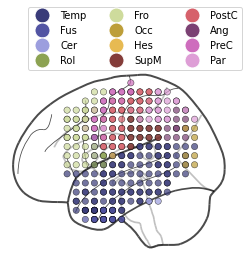

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))

region_cmap = matplotlib.cm.get_cmap('tab20b', len(roi_regions_df['Numbered Labels'].unique()))
region_colors = region_cmap(roi_regions_df['Numbered Labels'].unique())
region_colors = {roi_regions_df['NN Labels'].unique()[i]: region_colors[i] for i in range(len(roi_regions_df['Numbered Labels'].unique()))}

figu.plot_electrodes(axes, 
                pd.DataFrame(roi_centroids[0]),
                0, 
                electrode_color = roi_regions_df['Numbered Labels'],
                data_type='ROI',
                side_2_display="l", 
                colorbar=False, 
                alpha=1.0, 
                node_size=40, 
                node_cmap='tab20b',
                edgecolors='black')

axes.set_title("")
my_handles = [ Line2D([0], [0], marker='o', color='w', label=roi_region_shorthand[label], markerfacecolor=region_colors[label], markersize=15) for label in region_colors]
plt.legend(handles=my_handles, bbox_to_anchor=(1.05, 1), loc='lower right', borderaxespad=0., fontsize=10, ncol=3)

plt.show()

## Change to experimental

In [17]:
filepath = '/home/zsteineh/research_projects/NaturalisticNeuralManifolds/experiment_params/'
file_name = 'exp_params_exp_pca.json'
try:
    json_filename = filepath + file_name
except IndexError:
    raise SystemExit(f"Usage: {sys.argv[0]} <json file of experiment parameters>")
with open(json_filename) as f:
    exp_params = json.load(f)
print(exp_params['comment'])
pats_ids_in = exp_params["pats_ids_in"]

Param file for running PCA pipeline on experimental data


In [18]:
exp_params['test_day'] = 'last'
proj_mat_sp = exp_params["sp"] + exp_params["dataset"] + exp_params["experiment_folder"]
manifold_ECoG_data = ECoG_Data(exp_params, proj_mat_sp)


Determining ROIs


  0%|          | 0/5 [00:00<?, ?it/s]

ROIs found
Number of ROIs:  311
loading in fingerflex data
Pulling out last for test day


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

loading in fingerflex data
Pulling out last for test day


 40%|████      | 2/5 [00:01<00:02,  1.15it/s]

loading in fingerflex data
Pulling out last for test day


 60%|██████    | 3/5 [00:02<00:01,  1.15it/s]

loading in fingerflex data
Pulling out last for test day


 80%|████████  | 4/5 [00:03<00:00,  1.34it/s]

loading in fingerflex data
Pulling out last for test day


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Data loaded!


In [19]:
def load_elec_pos_exp(sbj_name):
    mni_elec_lp = '/data2/users/zsteineh/nm_paper_data/experimental_ecog_data/updated_data/elec_and_roi/'
    # sbj_name = f"S{sbj_num + 1:02d}"
    # lp = mni_elec_lp+sbj_name+'_MNI_converted.csv'
    lp = mni_elec_lp+sbj_name+'_elec_locs.csv'
    df_elec_pos = pd.read_csv(lp)
    # rename columns
    # df_elec_pos.columns = ['X coor', 'Y coor', 'Z coor']
    df_elec_pos.rename(columns={'x': 'X coor', 'y': 'Y coor', 'z': 'Z coor'}, inplace=True)
    return df_elec_pos

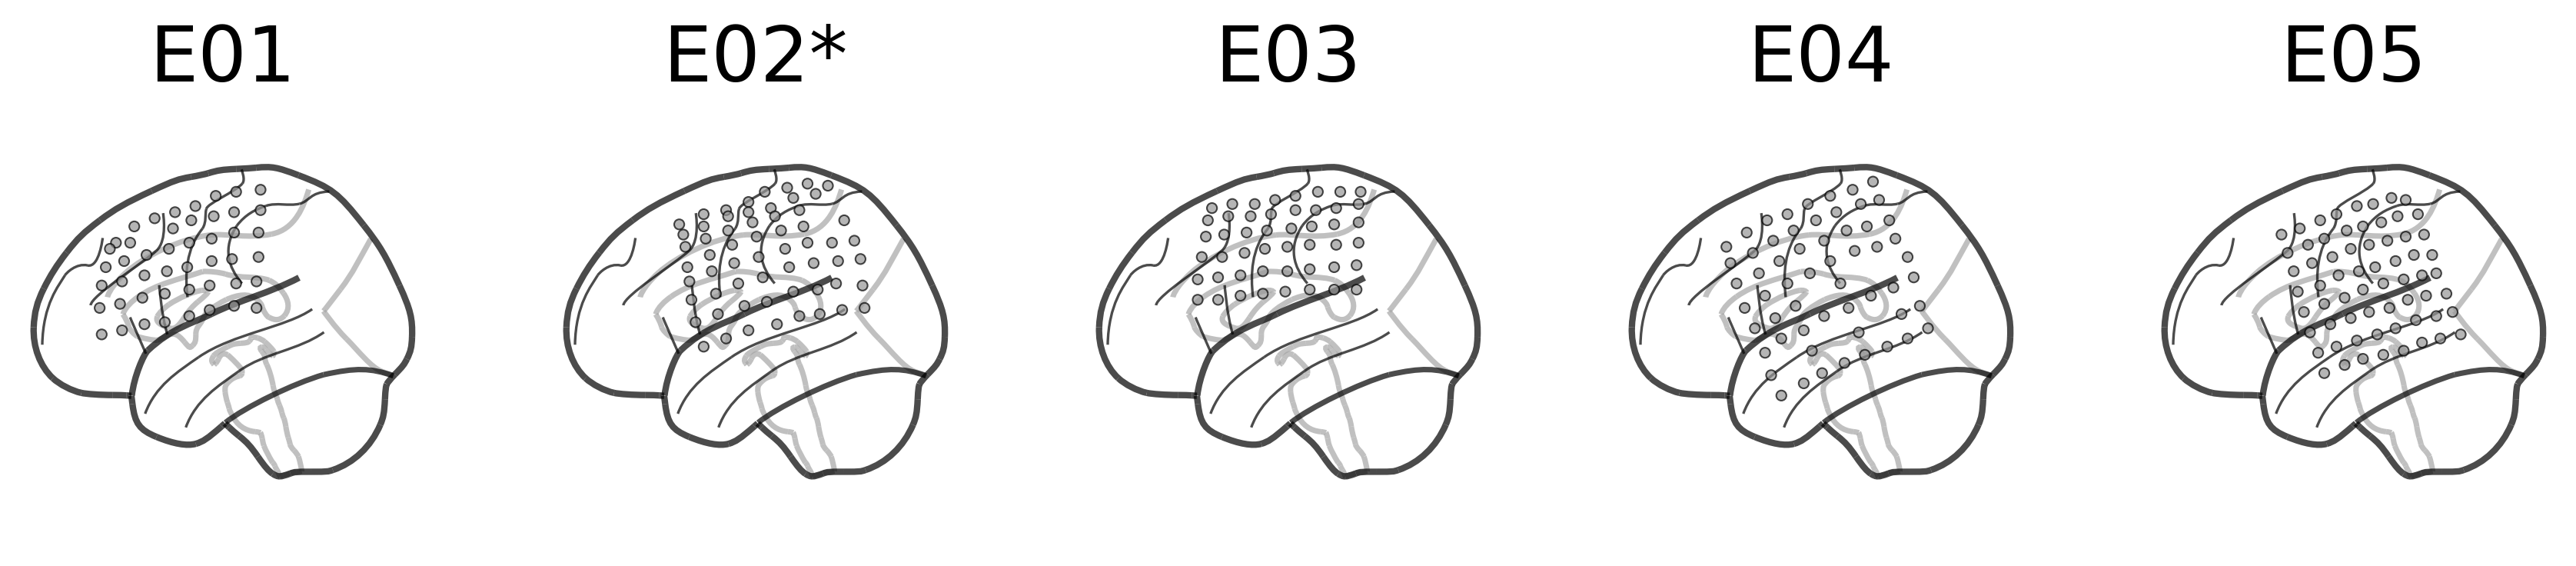

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(11.7, 2.5), dpi = 300)
plt.tight_layout()

for i, sbj in enumerate(pats_ids_in):
    elec_pos_df = load_elec_pos_exp(sbj)

    # print(elec_pos_df)
    figu.plot_electrodes(axes[i], 
                    elec_pos_df,
                    i, 
                    electrode_color=[2 for i in range(len(elec_pos_df))],
                    data_type='E',
                    side_2_display="l", 
                    colorbar=False, 
                    alpha=1.0, 
                    node_size=10, 
                    edgecolors='black')

axes[-1].axis('off')
plt.savefig('/home/zsteineh/research_projects/NaturalisticNeuralManifolds/figures/saved_figures/methods_exp_elecs.svg', bbox_inches='tight')    
plt.show()

In [21]:
pose_lp = '/data2/users/zsteineh/nm_paper_data/experimental_ecog_data/updated_data/pose/'
pose_file = 'E01_pose_data.nc'
pose_data = xr.open_dataset(pose_lp+pose_file)
print(pose_data)

pose_events = np.array(pose_data['__xarray_dataarray_variable__'])
pose_events = pose_events[:,0:5,:]
pose_labels = np.array(pose_data['events'])
np.unique(pose_labels)

<xarray.Dataset>
Dimensions:                        (channels: 6, events: 140, time: 1000)
Coordinates:
  * events                         (events) int64 4 4 1 3 4 3 2 ... 2 3 3 3 3 2
  * channels                       (channels) int64 0 1 2 3 4 5
  * time                           (time) float64 -2.0 -1.996 ... 1.992 1.996
Data variables:
    __xarray_dataarray_variable__  (events, channels, time) float64 ...


array([1, 2, 3, 4])

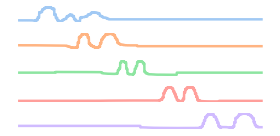

In [22]:
trial_to_plot = {'Thumb': 38,
               'Index': 0,
               'Middle': 10,
               'Ring': 5,
               'Pinky': 2,
               }
cur_classes = list(exp_class_colors.keys())[1:]

fig, axes = plt.subplots(5, 1, figsize=(4, 2))

start_time = 1400
for c, cur_class in enumerate(trial_to_plot):
    cur_trial = trial_to_plot[cur_class]
    data_to_plot = pose_events[cur_trial, c, :]
    # add zeros to beginning and end of data
    data_to_plot = np.concatenate((np.zeros(1000), data_to_plot, np.zeros(1000)))
    data_to_plot = data_to_plot[start_time:start_time+2000]
    axes[c].plot(data_to_plot, 
                c=exp_class_colors[cur_class], 
                label=cur_class, 
                linewidth=2.5)
    axes[c].axis('off')
    # plt.plot(pose_events[i, ...].T, c=exp_class_colors, alpha=0.5)
    # plt.legend()
    start_time -= 350
plt.tight_layout()
plt.savefig('/home/zsteineh/research_projects/NaturalisticNeuralManifolds/figures/saved_figures/methods_exp_pose.svg', bbox_inches='tight')
plt.show()

In [23]:
# get count of classes for all participants
pats_ids_in = exp_params['pats_ids_in']
class_dict = exp_params['class_dict']
pat_class_df = pd.DataFrame(columns=['Participant', 'Thumb', 'Index', 'Middle', 'Ring', 'Pinky'])
for p, pat in enumerate(pats_ids_in):
    manifold_ECoG_data.get_single_sbj(pat)
    train_labels_count = np.histogram(manifold_ECoG_data.sbj_y[:,0], bins=len(class_dict))[0]
    test_labels_count = np.histogram(manifold_ECoG_data.sbj_y_test[:,0], bins=len(class_dict))[0]
    all_labels_count = train_labels_count + test_labels_count
    pat_class_df = pat_class_df.append({'Participant': pat, 
                                        'Thumb': all_labels_count[0], 
                                        'Index': all_labels_count[1],
                                        'Middle': all_labels_count[2],
                                        'Ring': all_labels_count[3],
                                        'Pinky': all_labels_count[4]}, ignore_index=True)
    
print(pat_class_df)
exp_data_path = exp_params['ecog_lp']
pat_class_df.to_csv(os.path.join(exp_data_path, 'pat_class_df.csv'), index=False)

  Participant Thumb Index Middle Ring Pinky
0         E01    28    28     28   28    28
1         E02    27    27     27   27    27
2         E03    23    23     23   23    23
3         E04    10    10     10   10    10
4         E05    28    28     28   28    28
